In [ ]:
from torch import nn
from collections import OrderedDict
import torch.nn.functional as F
import torch
from torch.utils.data import DataLoader
import torchvision
import random
from torch.utils.data import Subset
from matplotlib import pyplot as plt
from torchsummary import summary
from torchvision import transforms
import progressbar as pb
import numpy as np

In [ ]:
SUM = lambda x,y : x+y

In [ ]:
def check_equity(property,a,b):
    pa = getattr(a,property)
    pb = getattr(b,property)
    assert  pa==pb, "Different {}: {}!={}".format(property,pa,pb)

    return pa

In [ ]:
def module_unwrap(mod:nn.Module,recursive=False):
    children = OrderedDict()
    try:
        for name, module in mod.named_children():
            if (recursive):
                recursive_call = module_unwrap(module,recursive=True)
                if (len(recursive_call)>0):
                    for k,v in recursive_call.items():
                        children[name+"_"+k] = v
                else:
                    children[name] = module
            else:
                children[name] = module
    except AttributeError:
        pass

    return children

In [ ]:
class VGGBlock(nn.Module):
    def __init__(self, in_channels, out_channels,batch_norm=False):

        super().__init__()

        conv2_params = {'kernel_size': (3, 3),
                        'stride'     : (1, 1),
                        'padding'   : 1
                        }

        noop = lambda x : x

        self._batch_norm = batch_norm

        self.conv1 = nn.Conv2d(in_channels=in_channels,out_channels=out_channels , **conv2_params)
        #self.bn1 = nn.BatchNorm2d(out_channels) if batch_norm else noop
        self.bn1 = nn.GroupNorm(32, out_channels) if batch_norm else noop

        self.conv2 = nn.Conv2d(in_channels=out_channels,out_channels=out_channels, **conv2_params)
        #self.bn2 = nn.BatchNorm2d(out_channels) if batch_norm else noop
        self.bn2 = nn.GroupNorm(32, out_channels) if batch_norm else noop

        self.max_pooling = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

    @property
    def batch_norm(self):
        return self._batch_norm

    def forward(self,x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)

        x = self.max_pooling(x)

        return x

In [ ]:
class Classifier(nn.Module):

    def __init__(self,num_classes=10):
        super().__init__()

        self.classifier = nn.Sequential(
            nn.Linear(2048, 2048),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.Linear(2048, 512),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self,x):

        return self.classifier(x)

In [ ]:
class VGG16(nn.Module):

  def __init__(self, input_size, batch_norm=False):
    super(VGG16, self).__init__()

    self.in_channels,self.in_width,self.in_height = input_size

    self.block_1 = VGGBlock(self.in_channels,64,batch_norm=batch_norm)
    self.block_2 = VGGBlock(64, 128,batch_norm=batch_norm)
    self.block_3 = VGGBlock(128, 256,batch_norm=batch_norm)
    self.block_4 = VGGBlock(256,512,batch_norm=batch_norm)


  @property
  def input_size(self):
      return self.in_channels,self.in_width,self.in_height

  def forward(self, x):

    x = self.block_1(x)
    x = self.block_2(x)
    x = self.block_3(x)
    x = self.block_4(x)
    # x = self.avgpool(x)
    x = torch.flatten(x,1)

    return x

In [ ]:
class CombinedLoss(nn.Module):
    def __init__(self, loss_a, loss_b, loss_combo, _lambda=1.0):
        super().__init__()
        self.loss_a = loss_a
        self.loss_b = loss_b
        self.loss_combo = loss_combo

        self.register_buffer('_lambda',torch.tensor(float(_lambda),dtype=torch.float32))


    def forward(self,y_hat,y):

        return self.loss_a(y_hat[0],y[0]) + self.loss_b(y_hat[1],y[1]) + self._lambda * self.loss_combo(y_hat[2],torch.cat(y,0))

----------------------------------------------------------------------

In [ ]:
DO='TRAIN'

In [ ]:
random.seed(47)

In [ ]:
combo_fn = SUM

In [ ]:
lambda_reg = 1

In [ ]:
def test(net,classifier, loader):

      net.to(dev)
      classifier.to(dev)

      net.eval()

      sum_accuracy = 0

      # Process each batch
      for j, (input, labels) in enumerate(loader):

        input = input.to(dev)
        labels = labels.float().to(dev)

        features = net(input)

        pred = torch.squeeze(classifier(features))

        # https://discuss.pytorch.org/t/bcewithlogitsloss-and-model-accuracy-calculation/59293/ 2
        #pred_labels = (pred >= 0.0).long()  # Binarize predictions to 0 and 1
        _,pred_label = torch.max(pred, dim = 1)
        pred_labels = (pred_label == labels).float()

        batch_accuracy = pred_labels.sum().item() / len(labels)

        # Update accuracy
        sum_accuracy += batch_accuracy

      epoch_accuracy = sum_accuracy / len(loader)
      return epoch_accuracy
      #print(f"Accuracy test: {epoch_accuracy:0.5}")

In [ ]:
def train(nets, loaders, optimizer, criterion, epochs=20, dev=None, save_param=False, model_name="valerio"):
    # try:
      nets = [n.to(dev) for n in nets]

      model_a = module_unwrap(nets[0], True)
      model_b = module_unwrap(nets[1], True)
      model_c = module_unwrap(nets[2], True)

      reg_loss = nn.MSELoss()

      criterion.to(dev)
      reg_loss.to(dev)

      # Initialize history
      history_loss = {"train": [], "val": [], "test": []}
      history_accuracy = {"train": [], "val": [], "test": []}
      history_test = []
      # Store the best val accuracy
      best_val_accuracy = 0

      # Process each epoch
      for epoch in range(epochs):
        # Initialize epoch variables
        sum_loss = {"train": 0, "val": 0, "test": 0}
        sum_accuracy = {"train": [0,0,0], "val": [0,0,0], "test": [0,0,0]}

        progbar = None
        # Process each split
        for split in ["train", "val", "test"]:
          if split == "train":
            for n in nets:
              n.train()
            widgets = [
              ' [', pb.Timer(), '] ',
              pb.Bar(),
              ' [', pb.ETA(), '] ', pb.Variable('ta','[Train Acc: {formatted_value}]')
            ]

            progbar = pb.ProgressBar(max_value=len(loaders[split][0]),widgets=widgets,redirect_stdout=True)

          else:
            for n in nets:
              n.eval()
          # Process each batch
          for j,((input_a, labels_a),(input_b, labels_b)) in enumerate(zip(loaders[split][0],loaders[split][1])):

            input_a = input_a.to(dev)
            input_b = input_b.to(dev)

            labels_a = labels_a.long().to(dev)
            labels_b = labels_b.long().to(dev)
            #print(labels_a.shape)
            #labels_a = labels_a.squeeze()
            #labels_b = labels_b.squeeze()
            
            #labels_a = labels_a.unsqueeze(1)
            #labels_b = labels_b.unsqueeze(1)
            #print(labels_a.shape)
            #labels_a = labels_a.argmax(-1)
            #labels_b = labels_b.argmax(-1)

            inputs = torch.cat([input_a,input_b],axis=0)
            labels = torch.cat([labels_a, labels_b])

            #labels  = labels.squeeze()
            #print(labels.shape)
            #labels = labels.argmax(-1)

            # Reset gradients
            optimizer.zero_grad()
            # Compute output
            features_a = nets[0](input_a)
            features_b = nets[1](input_b)
            features_c = nets[2](inputs)

            pred_a = torch.squeeze(nets[3](features_a))
            pred_b = torch.squeeze(nets[3](features_b))
            pred_c = torch.squeeze(nets[3](features_c))

            loss = criterion(pred_a, labels_a) + criterion(pred_b, labels_b) + criterion(pred_c, labels)

            for n in model_a:
              layer_a = model_a[n]
              layer_b = model_b[n]
              layer_c = model_c[n]
              if (isinstance(layer_a,nn.Conv2d)):
                loss += lambda_reg * reg_loss(combo_fn(layer_a.weight,layer_b.weight),layer_c.weight)
                if (layer_a.bias is not None):
                  loss += lambda_reg * reg_loss(combo_fn(layer_a.bias, layer_b.bias), layer_c.bias)

            # Update loss
            sum_loss[split] += loss.item()
            # Check parameter update
            if split == "train":
              # Compute gradients
              loss.backward()
              # Optimize
              optimizer.step()

            # Compute accuracy

            #https://discuss.pytorch.org/t/bcewithlogitsloss-and-model-accuracy-calculation/59293/ 2
            #pred_labels_a = (pred_a >= 0.0).long()  # Binarize predictions to 0 and 1
            #pred_labels_b = (pred_b >= 0.0).long()  # Binarize predictions to 0 and 1
            #pred_labels_c = (pred_c >= 0.0).long()  # Binarize predictions to 0 and 1

            #print(pred_a.shape)

            _,pred_label_a = torch.max(pred_a, dim = 1)
            pred_labels_a = (pred_label_a == labels_a).float()

            _,pred_label_b = torch.max(pred_b, dim = 1)
            pred_labels_b = (pred_label_b == labels_b).float()

            _,pred_label_c = torch.max(pred_c, dim = 1)
            pred_labels_c = (pred_label_c == labels).float()

            batch_accuracy_a = pred_labels_a.sum().item() / len(labels_a)
            batch_accuracy_b = pred_labels_b.sum().item() / len(labels_b)
            batch_accuracy_c = pred_labels_c.sum().item() / len(labels)

            # Update accuracy
            sum_accuracy[split][0] += batch_accuracy_a
            sum_accuracy[split][1] += batch_accuracy_b
            sum_accuracy[split][2] += batch_accuracy_c


            if (split=='train'):
              progbar.update(j, ta=batch_accuracy_c)

        if (progbar is not None):
          progbar.finish()
        # Compute epoch loss/accuracy
        epoch_loss = {split: sum_loss[split] / len(loaders[split][0]) for split in ["train", "val", "test"]}
        epoch_accuracy = {split: [sum_accuracy[split][i] / len(loaders[split][0]) for i in range(len(sum_accuracy[split])) ] for split in ["train", "val", "test"]}

        # # Store params at the best validation accuracy
        # if save_param and epoch_accuracy["val"] > best_val_accuracy:
        #   # torch.save(net.state_dict(), f"{net.__class__.__name__}_best_val.pth")
        #   torch.save(net.state_dict(), f"{model_name}_best_val.pth")
        #   best_val_accuracy = epoch_accuracy["val"]

        print(f"Epoch {epoch + 1}:")
        # Update history
        for split in ["train", "val", "test"]:
          history_loss[split].append(epoch_loss[split])
          history_accuracy[split].append(epoch_accuracy[split])
          # Print info
          print(f"\t{split}\tLoss: {epoch_loss[split]:0.5}\tVGG 1:{epoch_accuracy[split][0]:0.5}"
                f"\tVGG 2:{epoch_accuracy[split][1]:0.5}\tVGG *:{epoch_accuracy[split][2]:0.5}")

        if save_param:
          torch.save({'vgg_a':nets[0].state_dict(),'vgg_b':nets[1].state_dict(),'vgg_star':nets[2].state_dict(),'classifier':nets[3].state_dict()},f'{model_name}.pth')


        
        print(f"Accuracy test VGGA: {test(nets[0], nets[3], test_loader_all):0.5}")
        print(f"Accuracy test VGGB: {test(nets[1], nets[3], test_loader_all):0.5}")
        print(f"Accuracy test VGG*: {test(nets[2], nets[3], test_loader_all):0.5}")
 
        summed_state_dict = OrderedDict()
 
        for key in nets[2].state_dict():
          if key.find('conv') >=0:
            #print(key)
            summed_state_dict[key] = combo_fn(nets[0].state_dict()[key],nets[1].state_dict()[key])
          else:
            summed_state_dict[key] = nets[2].state_dict()[key]
 
        nets[2].load_state_dict(summed_state_dict)
        accuracy_star = test(nets[2], nets[3], test_loader_all)
        print(f"Accuracy test VGGSTAR: {accuracy_star:0.5}")
        history_test.append(accuracy_star)


      # Plot accuracy
      plt.title("Accuracy VGGSTAR over epochs")
      plt.plot(history_test)
      #plt.legend()
      plt.show()


In [ ]:
root_dir = './'

In [ ]:
rescale_data = transforms.Lambda(lambda x : x/255)

# Compose transformations
data_transform = transforms.Compose([
  transforms.Resize(32),
  transforms.RandomHorizontalFlip(),
  transforms.ToTensor(),
  rescale_data,
  #transforms.Normalize((-0.7376), (0.5795))
])

test_transform = transforms.Compose([
  transforms.Resize(32),
  transforms.ToTensor(),
  rescale_data,
  #transforms.Normalize((0.1327), (0.2919))
])

In [ ]:
# Load MNIST dataset with transforms
train_set = torchvision.datasets.MNIST(root=root_dir, train=True, download=True, transform=data_transform)
test_set = torchvision.datasets.MNIST(root=root_dir, train=False, download=True, transform=test_transform)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
train_idx = np.random.permutation(np.arange(len(train_set)))
test_idx = np.arange(len(test_set))

val_frac = 0.1

n_val = int(len(train_idx) * val_frac)
val_idx = train_idx[0:n_val]
train_idx = train_idx[n_val:]

h = len(train_idx)//2

train_set_a = Subset(train_set,train_idx[0:h])
train_set_b = Subset(train_set,train_idx[h:])

h = len(val_idx)//2

val_set_a = Subset(train_set,val_idx[0:h])
val_set_b = Subset(train_set,val_idx[h:])

h = len(test_idx)//2

test_set_a = Subset(test_set,test_idx[0:h])
test_set_b = Subset(test_set,test_idx[h:])

In [ ]:
# Define loaders

train_loader_a = DataLoader(train_set_a, batch_size=64, num_workers=0, shuffle=True, drop_last=True)
val_loader_a   = DataLoader(val_set_a,   batch_size=64, num_workers=0, shuffle=False, drop_last=False)
test_loader_a  = DataLoader(test_set_a,  batch_size=64, num_workers=0, shuffle=False, drop_last=False)

train_loader_b = DataLoader(train_set_b, batch_size=64, num_workers=0, shuffle=True, drop_last=True)
val_loader_b   = DataLoader(val_set_b,   batch_size=64, num_workers=0, shuffle=False, drop_last=False)
test_loader_b  = DataLoader(test_set_b,  batch_size=64, num_workers=0, shuffle=False, drop_last=False)

test_loader_all = DataLoader(test_set,batch_size=64, num_workers=0,shuffle=False,drop_last=False)


# Define dictionary of loaders
loaders = {"train": [train_loader_a,train_loader_b],
           "val":   [val_loader_a,val_loader_b],
           "test":  [test_loader_a,test_loader_b]}

In [ ]:
class VGG16INIT(nn.Module):

  def __init__(self, input_size, model1, model2, batch_norm=False):
    super(VGG16INIT, self).__init__()

    self.in_channels,self.in_width,self.in_height = input_size

    self.block_1 = VGGBlock(self.in_channels,64,batch_norm=batch_norm)
    self.block_2 = VGGBlock(64, 128,batch_norm=batch_norm)
    self.block_3 = VGGBlock(128, 256,batch_norm=batch_norm)
    self.block_4 = VGGBlock(256,512,batch_norm=batch_norm)

    for p_out, p_in1, p_in2 in zip(self.parameters(), model1.parameters(), model2.parameters()):
            p_out.data = nn.Parameter(p_in1 +p_in2);

  @property
  def input_size(self):
      return self.in_channels,self.in_width,self.in_height


  def forward(self, x):

    x = self.block_1(x)
    x = self.block_2(x)
    x = self.block_3(x)
    x = self.block_4(x)
    # x = self.avgpool(x)
    x = torch.flatten(x,1)

    return x

In [ ]:
model1 = VGG16((1,32,32),batch_norm=True)
model2 = VGG16((1,32,32),batch_norm=True)
model3 = VGG16((1,32,32),batch_norm=True)
#model3 = VGG16INIT((1,32,32),model1,model2,batch_norm=True)
classifier = Classifier(num_classes=10)

In [ ]:
#list(model1.parameters())

In [ ]:
#list(model2.parameters())

In [ ]:
#list(model3.parameters())

In [ ]:
nets = [model1,model2,model3,classifier]

In [ ]:
dev = torch.device('cuda')

In [ ]:
parameters = set()

In [ ]:
for n in nets:
  parameters |= set(n.parameters())

In [ ]:
optimizer = torch.optim.SGD(parameters, lr = 0.01)
# Define a loss
#criterion = nn.BCEWithLogitsLoss()#,nn.BCEWithLogitsLoss(),nn.BCEWithLogitsLoss(),_lambda = 1)
criterion = nn.CrossEntropyLoss()
n_params = 0

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
 [Elapsed Time: 0:01:03] |###############| [Time:  0:01:03] [Train Acc:  0.195]


Epoch 1:
	train	Loss: 7.0447	VGG 1:0.12236	VGG 2:0.1165	VGG *:0.13964
	val	Loss: 6.7495	VGG 1:0.21011	VGG 2:0.18413	VGG *:0.11799
	test	Loss: 6.7386	VGG 1:0.19106	VGG 2:0.21479	VGG *:0.12075
Accuracy test VGGA: 0.20084
Accuracy test VGGB: 0.18272
Accuracy test VGG*: 0.12102
Accuracy test VGGSTAR: 0.11355


 [Elapsed Time: 0:01:03] |###############| [Time:  0:01:03] [Train Acc:  0.312]


Epoch 2:
	train	Loss: 6.4306	VGG 1:0.22361	VGG 2:0.19366	VGG *:0.18438
	val	Loss: 5.1027	VGG 1:0.43223	VGG 2:0.44002	VGG *:0.42966
	test	Loss: 5.1835	VGG 1:0.40625	VGG 2:0.41238	VGG *:0.4289
Accuracy test VGGA: 0.43501
Accuracy test VGGB: 0.40406
Accuracy test VGG*: 0.42755
Accuracy test VGGSTAR: 0.19019


 [Elapsed Time: 0:01:03] |###############| [Time:  0:01:03] [Train Acc:  0.656]


Epoch 3:
	train	Loss: 4.0995	VGG 1:0.53789	VGG 2:0.44767	VGG *:0.56257
	val	Loss: 2.4699	VGG 1:0.73362	VGG 2:0.73271	VGG *:0.67767
	test	Loss: 2.4333	VGG 1:0.71143	VGG 2:0.76266	VGG *:0.67811
Accuracy test VGGA: 0.74711
Accuracy test VGGB: 0.72034
Accuracy test VGG*: 0.67655
Accuracy test VGGSTAR: 0.44437


 [Elapsed Time: 0:01:03] |###############| [Time:  0:01:03] [Train Acc:  0.883]


Epoch 4:
	train	Loss: 2.0192	VGG 1:0.78674	VGG 2:0.76462	VGG *:0.77219
	val	Loss: 1.2176	VGG 1:0.86764	VGG 2:0.86845	VGG *:0.87716
	test	Loss: 1.1906	VGG 1:0.83406	VGG 2:0.90111	VGG *:0.87807
Accuracy test VGGA: 0.86783
Accuracy test VGGB: 0.86724
Accuracy test VGG*: 0.87838
Accuracy test VGGSTAR: 0.64908


 [Elapsed Time: 0:01:03] |###############| [Time:  0:01:03] [Train Acc:  0.938]


Epoch 5:
	train	Loss: 1.3508	VGG 1:0.89567	VGG 2:0.88628	VGG *:0.7808
	val	Loss: 0.80817	VGG 1:0.91394	VGG 2:0.92691	VGG *:0.9044
	test	Loss: 0.77697	VGG 1:0.89082	VGG 2:0.95115	VGG *:0.9103
Accuracy test VGGA: 0.91401
Accuracy test VGGB: 0.93352
Accuracy test VGG*: 0.91083
Accuracy test VGGSTAR: 0.56419


 [Elapsed Time: 0:01:03] |###############| [Time:  0:01:03] [Train Acc:  0.922]


Epoch 6:
	train	Loss: 0.91696	VGG 1:0.92136	VGG 2:0.92139	VGG *:0.86483
	val	Loss: 0.57421	VGG 1:0.93859	VGG 2:0.94301	VGG *:0.93363
	test	Loss: 0.53397	VGG 1:0.93078	VGG 2:0.95767	VGG *:0.9379
Accuracy test VGGA: 0.94427
Accuracy test VGGB: 0.94367
Accuracy test VGG*: 0.9379
Accuracy test VGGSTAR: 0.59942


 [Elapsed Time: 0:01:03] |###############| [Time:  0:01:03] [Train Acc:   0.93]


Epoch 7:
	train	Loss: 1.4163	VGG 1:0.93368	VGG 2:0.91356	VGG *:0.75859
	val	Loss: 0.76552	VGG 1:0.94524	VGG 2:0.94059	VGG *:0.93185
	test	Loss: 0.73853	VGG 1:0.9282	VGG 2:0.96104	VGG *:0.93523
Accuracy test VGGA: 0.94676
Accuracy test VGGB: 0.94049
Accuracy test VGG*: 0.93491
Accuracy test VGGSTAR: 0.60918


 [Elapsed Time: 0:01:03] |###############| [Time:  0:01:03] [Train Acc:  0.914]


Epoch 8:
	train	Loss: 1.1688	VGG 1:0.94897	VGG 2:0.91274	VGG *:0.76837
	val	Loss: 0.59238	VGG 1:0.93892	VGG 2:0.95061	VGG *:0.93211
	test	Loss: 0.54563	VGG 1:0.93078	VGG 2:0.97033	VGG *:0.9373
Accuracy test VGGA: 0.94516
Accuracy test VGGB: 0.95233
Accuracy test VGG*: 0.9373
Accuracy test VGGSTAR: 0.71059


 [Elapsed Time: 0:01:03] |###############| [Time:  0:01:03] [Train Acc:  0.922]


Epoch 9:
	train	Loss: 0.6791	VGG 1:0.95483	VGG 2:0.9493	VGG *:0.88359
	val	Loss: 0.40577	VGG 1:0.96229	VGG 2:0.96129	VGG *:0.95106
	test	Loss: 0.39266	VGG 1:0.94521	VGG 2:0.9729	VGG *:0.95243
Accuracy test VGGA: 0.96139
Accuracy test VGGB: 0.96148
Accuracy test VGG*: 0.95223
Accuracy test VGGSTAR: 0.83061


 [Elapsed Time: 0:01:03] |###############| [Time:  0:01:03] [Train Acc:  0.945]


Epoch 10:
	train	Loss: 0.57869	VGG 1:0.95973	VGG 2:0.95821	VGG *:0.89868
	val	Loss: 0.39198	VGG 1:0.96391	VGG 2:0.95797	VGG *:0.94876
	test	Loss: 0.3676	VGG 1:0.95866	VGG 2:0.97409	VGG *:0.95105
Accuracy test VGGA: 0.96805
Accuracy test VGGB: 0.96338
Accuracy test VGG*: 0.95044
Accuracy test VGGSTAR: 0.80175


 [Elapsed Time: 0:01:03] |###############| [Time:  0:01:03] [Train Acc:  0.977]


Epoch 11:
	train	Loss: 0.48693	VGG 1:0.96671	VGG 2:0.96211	VGG *:0.92097
	val	Loss: 0.37344	VGG 1:0.96462	VGG 2:0.97003	VGG *:0.95177
	test	Loss: 0.35771	VGG 1:0.9551	VGG 2:0.98141	VGG *:0.95332
Accuracy test VGGA: 0.96586
Accuracy test VGGB: 0.97154
Accuracy test VGG*: 0.95412
Accuracy test VGGSTAR: 0.7084


 [Elapsed Time: 0:01:03] |###############| [Time:  0:01:03] [Train Acc:  0.945]


Epoch 12:
	train	Loss: 0.502	VGG 1:0.97187	VGG 2:0.96155	VGG *:0.90913
	val	Loss: 0.33974	VGG 1:0.96391	VGG 2:0.96932	VGG *:0.95935
	test	Loss: 0.35073	VGG 1:0.95134	VGG 2:0.97785	VGG *:0.96114
Accuracy test VGGA: 0.96288
Accuracy test VGGB: 0.96835
Accuracy test VGG*: 0.96089
Accuracy test VGGSTAR: 0.82434


 [Elapsed Time: 0:01:03] |###############| [Time:  0:01:03] [Train Acc:   0.93]


Epoch 13:
	train	Loss: 0.46224	VGG 1:0.97402	VGG 2:0.96871	VGG *:0.91571
	val	Loss: 0.33669	VGG 1:0.96913	VGG 2:0.9696	VGG *:0.95956
	test	Loss: 0.3407	VGG 1:0.96025	VGG 2:0.97844	VGG *:0.9553
Accuracy test VGGA: 0.97064
Accuracy test VGGB: 0.96656
Accuracy test VGG*: 0.95541
Accuracy test VGGSTAR: 0.87112


 [Elapsed Time: 0:01:03] |###############| [Time:  0:01:03] [Train Acc:  0.961]


Epoch 14:
	train	Loss: 0.56318	VGG 1:0.97677	VGG 2:0.97142	VGG *:0.87491
	val	Loss: 0.32404	VGG 1:0.97364	VGG 2:0.9697	VGG *:0.95761
	test	Loss: 0.28903	VGG 1:0.97172	VGG 2:0.97844	VGG *:0.95965
Accuracy test VGGA: 0.97751
Accuracy test VGGB: 0.96447
Accuracy test VGG*: 0.95939
Accuracy test VGGSTAR: 0.66212


 [Elapsed Time: 0:01:03] |###############| [Time:  0:01:03] [Train Acc:  0.969]


Epoch 15:
	train	Loss: 0.49844	VGG 1:0.97873	VGG 2:0.97447	VGG *:0.8905
	val	Loss: 0.3208	VGG 1:0.9707	VGG 2:0.965	VGG *:0.95992
	test	Loss: 0.27938	VGG 1:0.96499	VGG 2:0.98062	VGG *:0.96539
Accuracy test VGGA: 0.97422
Accuracy test VGGB: 0.96984
Accuracy test VGG*: 0.96517
Accuracy test VGGSTAR: 0.91411


 [Elapsed Time: 0:01:03] |###############| [Time:  0:01:03] [Train Acc:  0.883]


Epoch 16:
	train	Loss: 0.28451	VGG 1:0.98159	VGG 2:0.97554	VGG *:0.95268
	val	Loss: 0.47337	VGG 1:0.97602	VGG 2:0.97792	VGG *:0.89941
	test	Loss: 0.44993	VGG 1:0.9642	VGG 2:0.98517	VGG *:0.91307
Accuracy test VGGA: 0.97492
Accuracy test VGGB: 0.97512
Accuracy test VGG*: 0.91262
Accuracy test VGGSTAR: 0.86107


 [Elapsed Time: 0:01:03] |###############| [Time:  0:01:03] [Train Acc:  0.977]


Epoch 17:
	train	Loss: 0.33846	VGG 1:0.98174	VGG 2:0.97821	VGG *:0.93145
	val	Loss: 0.25096	VGG 1:0.97502	VGG 2:0.98005	VGG *:0.96866
	test	Loss: 0.23291	VGG 1:0.96796	VGG 2:0.98734	VGG *:0.97251
Accuracy test VGGA: 0.97731
Accuracy test VGGB: 0.9788
Accuracy test VGG*: 0.97233
Accuracy test VGGSTAR: 0.90078


 [Elapsed Time: 0:01:03] |###############| [Time:  0:01:03] [Train Acc:  0.977]


Epoch 18:
	train	Loss: 0.24609	VGG 1:0.98263	VGG 2:0.98126	VGG *:0.95947
	val	Loss: 0.2191	VGG 1:0.97559	VGG 2:0.98096	VGG *:0.97378
	test	Loss: 0.21059	VGG 1:0.97112	VGG 2:0.98892	VGG *:0.97389
Accuracy test VGGA: 0.98
Accuracy test VGGB: 0.98
Accuracy test VGG*: 0.97373
Accuracy test VGGSTAR: 0.9167


 [Elapsed Time: 0:01:03] |###############| [Time:  0:01:03] [Train Acc:  0.992]


Epoch 19:
	train	Loss: 0.24002	VGG 1:0.98534	VGG 2:0.98159	VGG *:0.95736
	val	Loss: 0.22792	VGG 1:0.97502	VGG 2:0.97929	VGG *:0.97295
	test	Loss: 0.21295	VGG 1:0.97093	VGG 2:0.98774	VGG *:0.97656
Accuracy test VGGA: 0.9794
Accuracy test VGGB: 0.9797
Accuracy test VGG*: 0.97641
Accuracy test VGGSTAR: 0.90466


 [Elapsed Time: 0:01:03] |###############| [Time:  0:01:03] [Train Acc:  0.977]


Epoch 20:
	train	Loss: 0.40692	VGG 1:0.98605	VGG 2:0.98404	VGG *:0.89712
	val	Loss: 0.27897	VGG 1:0.97701	VGG 2:0.97701	VGG *:0.95514
	test	Loss: 0.25583	VGG 1:0.96915	VGG 2:0.98754	VGG *:0.96084
Accuracy test VGGA: 0.9789
Accuracy test VGGB: 0.97661
Accuracy test VGG*: 0.96129
Accuracy test VGGSTAR: 0.88575


 [Elapsed Time: 0:01:03] |###############| [Time:  0:01:03] [Train Acc:  0.984]


Epoch 21:
	train	Loss: 0.21832	VGG 1:0.98738	VGG 2:0.98449	VGG *:0.95884
	val	Loss: 0.25944	VGG 1:0.98001	VGG 2:0.97701	VGG *:0.96212
	test	Loss: 0.23366	VGG 1:0.97369	VGG 2:0.98873	VGG *:0.96549
Accuracy test VGGA: 0.98139
Accuracy test VGGB: 0.9796
Accuracy test VGG*: 0.96527
Accuracy test VGGSTAR: 0.90257


 [Elapsed Time: 0:01:03] |###############| [Time:  0:01:03] [Train Acc:  0.977]


Epoch 22:
	train	Loss: 0.19447	VGG 1:0.98927	VGG 2:0.98605	VGG *:0.96313
	val	Loss: 0.32512	VGG 1:0.96979	VGG 2:0.98134	VGG *:0.94669
	test	Loss: 0.30229	VGG 1:0.96875	VGG 2:0.98734	VGG *:0.94956
Accuracy test VGGA: 0.9786
Accuracy test VGGB: 0.98139
Accuracy test VGG*: 0.94964
Accuracy test VGGSTAR: 0.89471


 [Elapsed Time: 0:01:03] |###############| [Time:  0:01:03] [Train Acc:  0.992]


Epoch 23:
	train	Loss: 0.18839	VGG 1:0.98861	VGG 2:0.9879	VGG *:0.96428
	val	Loss: 0.21082	VGG 1:0.97934	VGG 2:0.98267	VGG *:0.9763
	test	Loss: 0.18384	VGG 1:0.97745	VGG 2:0.98952	VGG *:0.97725
Accuracy test VGGA: 0.98388
Accuracy test VGGB: 0.9799
Accuracy test VGG*: 0.97711
Accuracy test VGGSTAR: 0.87122


 [Elapsed Time: 0:01:03] |###############| [Time:  0:01:03] [Train Acc:  0.992]


Epoch 24:
	train	Loss: 0.18524	VGG 1:0.99009	VGG 2:0.98727	VGG *:0.96253
	val	Loss: 0.20488	VGG 1:0.98067	VGG 2:0.981	VGG *:0.97595
	test	Loss: 0.19461	VGG 1:0.97369	VGG 2:0.98794	VGG *:0.97716
Accuracy test VGGA: 0.98089
Accuracy test VGGB: 0.98268
Accuracy test VGG*: 0.97701
Accuracy test VGGSTAR: 0.88286


 [Elapsed Time: 0:01:03] |###############| [Time:  0:01:03] [Train Acc:  0.969]


Epoch 25:
	train	Loss: 0.18794	VGG 1:0.99076	VGG 2:0.99016	VGG *:0.96092
	val	Loss: 0.2177	VGG 1:0.98138	VGG 2:0.98267	VGG *:0.96927
	test	Loss: 0.2104	VGG 1:0.97172	VGG 2:0.98813	VGG *:0.97122
Accuracy test VGGA: 0.9796
Accuracy test VGGB: 0.98179
Accuracy test VGG*: 0.97104
Accuracy test VGGSTAR: 0.88475


 [Elapsed Time: 0:01:03] |###############| [Time:  0:01:03] [Train Acc:  0.977]


Epoch 26:
	train	Loss: 0.17644	VGG 1:0.99143	VGG 2:0.99068	VGG *:0.96187
	val	Loss: 0.20174	VGG 1:0.98034	VGG 2:0.984	VGG *:0.97528
	test	Loss: 0.17119	VGG 1:0.97725	VGG 2:0.99169	VGG *:0.97824
Accuracy test VGGA: 0.98298
Accuracy test VGGB: 0.98328
Accuracy test VGG*: 0.97811
Accuracy test VGGSTAR: 0.91172


 [Elapsed Time: 0:01:03] |###############| [Time:  0:01:03] [Train Acc:  0.969]


Epoch 27:
	train	Loss: 0.1599	VGG 1:0.9918	VGG 2:0.99117	VGG *:0.96654
	val	Loss: 0.20436	VGG 1:0.97763	VGG 2:0.98371	VGG *:0.97614
	test	Loss: 0.19418	VGG 1:0.97271	VGG 2:0.9907	VGG *:0.97636
Accuracy test VGGA: 0.98139
Accuracy test VGGB: 0.98139
Accuracy test VGG*: 0.97621
Accuracy test VGGSTAR: 0.92406


 [Elapsed Time: 0:01:04] |###############| [Time:  0:01:04] [Train Acc:  0.977]


Epoch 28:
	train	Loss: 0.18034	VGG 1:0.99158	VGG 2:0.99224	VGG *:0.96162
	val	Loss: 0.2293	VGG 1:0.98167	VGG 2:0.98295	VGG *:0.97231
	test	Loss: 0.20732	VGG 1:0.97409	VGG 2:0.98991	VGG *:0.97429
Accuracy test VGGA: 0.98139
Accuracy test VGGB: 0.98229
Accuracy test VGG*: 0.97412
Accuracy test VGGSTAR: 0.90565


 [Elapsed Time: 0:01:03] |###############| [Time:  0:01:03] [Train Acc:  0.953]


Epoch 29:
	train	Loss: 0.14926	VGG 1:0.99336	VGG 2:0.99098	VGG *:0.96797
	val	Loss: 0.19529	VGG 1:0.98001	VGG 2:0.98461	VGG *:0.97644
	test	Loss: 0.17948	VGG 1:0.97627	VGG 2:0.99169	VGG *:0.98062
Accuracy test VGGA: 0.98258
Accuracy test VGGB: 0.98328
Accuracy test VGG*: 0.98049
Accuracy test VGGSTAR: 0.93123


 [Elapsed Time: 0:01:03] |###############| [Time:  0:01:03] [Train Acc:  0.961]


Epoch 30:
	train	Loss: 0.1351	VGG 1:0.99287	VGG 2:0.99388	VGG *:0.96916
	val	Loss: 0.21743	VGG 1:0.98105	VGG 2:0.98494	VGG *:0.97029
	test	Loss: 0.19506	VGG 1:0.97488	VGG 2:0.99051	VGG *:0.97528
Accuracy test VGGA: 0.98079
Accuracy test VGGB: 0.98238
Accuracy test VGG*: 0.97512
Accuracy test VGGSTAR: 0.93223


 [Elapsed Time: 0:01:03] |###############| [Time:  0:01:03] [Train Acc:  0.992]


Epoch 31:
	train	Loss: 0.14417	VGG 1:0.99529	VGG 2:0.99299	VGG *:0.96663
	val	Loss: 0.19951	VGG 1:0.981	VGG 2:0.98566	VGG *:0.9758
	test	Loss: 0.19563	VGG 1:0.97251	VGG 2:0.99288	VGG *:0.97844
Accuracy test VGGA: 0.98189
Accuracy test VGGB: 0.98676
Accuracy test VGG*: 0.9783
Accuracy test VGGSTAR: 0.89142


 [Elapsed Time: 0:01:03] |###############| [Time:  0:01:03] [Train Acc:  0.969]


Epoch 32:
	train	Loss: 0.1336	VGG 1:0.99473	VGG 2:0.9954	VGG *:0.9678
	val	Loss: 0.21061	VGG 1:0.97597	VGG 2:0.98732	VGG *:0.97281
	test	Loss: 0.22615	VGG 1:0.96697	VGG 2:0.9911	VGG *:0.97508
Accuracy test VGGA: 0.97811
Accuracy test VGGB: 0.98368
Accuracy test VGG*: 0.97492
Accuracy test VGGSTAR: 0.90167


 [Elapsed Time: 0:01:04] |###############| [Time:  0:01:04] [Train Acc:  0.977]


Epoch 33:
	train	Loss: 0.13171	VGG 1:0.99447	VGG 2:0.99499	VGG *:0.96873
	val	Loss: 0.21679	VGG 1:0.97768	VGG 2:0.98157	VGG *:0.97635
	test	Loss: 0.21489	VGG 1:0.97053	VGG 2:0.98952	VGG *:0.97765
Accuracy test VGGA: 0.9785
Accuracy test VGGB: 0.98149
Accuracy test VGG*: 0.97751
Accuracy test VGGSTAR: 0.86107


 [Elapsed Time: 0:01:03] |###############| [Time:  0:01:03] [Train Acc:  0.984]


Epoch 34:
	train	Loss: 0.13237	VGG 1:0.99269	VGG 2:0.99551	VGG *:0.96819
	val	Loss: 0.20404	VGG 1:0.98005	VGG 2:0.98599	VGG *:0.97898
	test	Loss: 0.18008	VGG 1:0.97844	VGG 2:0.9907	VGG *:0.98091
Accuracy test VGGA: 0.98318
Accuracy test VGGB: 0.98487
Accuracy test VGG*: 0.98079
Accuracy test VGGSTAR: 0.90675


 [Elapsed Time: 0:01:03] |###############| [Time:  0:01:03] [Train Acc:  0.977]


Epoch 35:
	train	Loss: 0.16664	VGG 1:0.99469	VGG 2:0.9954	VGG *:0.95865
	val	Loss: 0.21393	VGG 1:0.98105	VGG 2:0.98466	VGG *:0.97628
	test	Loss: 0.17475	VGG 1:0.97725	VGG 2:0.9913	VGG *:0.98032
Accuracy test VGGA: 0.98358
Accuracy test VGGB: 0.98099
Accuracy test VGG*: 0.9802
Accuracy test VGGSTAR: 0.90953


 [Elapsed Time: 0:01:03] |###############| [Time:  0:01:03] [Train Acc:    1.0]


Epoch 36:
	train	Loss: 0.12077	VGG 1:0.99562	VGG 2:0.99633	VGG *:0.9696
	val	Loss: 0.18364	VGG 1:0.98029	VGG 2:0.98737	VGG *:0.97837
	test	Loss: 0.18068	VGG 1:0.97429	VGG 2:0.99209	VGG *:0.97943
Accuracy test VGGA: 0.98229
Accuracy test VGGB: 0.98557
Accuracy test VGG*: 0.9793
Accuracy test VGGSTAR: 0.92924


 [Elapsed Time: 0:01:03] |###############| [Time:  0:01:03] [Train Acc:  0.984]


Epoch 37:
	train	Loss: 0.11173	VGG 1:0.99644	VGG 2:0.99666	VGG *:0.97166
	val	Loss: 0.24174	VGG 1:0.97868	VGG 2:0.98058	VGG *:0.97124
	test	Loss: 0.23525	VGG 1:0.97271	VGG 2:0.98556	VGG *:0.97399
Accuracy test VGGA: 0.98059
Accuracy test VGGB: 0.97691
Accuracy test VGG*: 0.97383
Accuracy test VGGSTAR: 0.88018


 [Elapsed Time: 0:01:03] |###############| [Time:  0:01:03] [Train Acc:  0.984]


Epoch 38:
	train	Loss: 0.11894	VGG 1:0.99414	VGG 2:0.99659	VGG *:0.97153
	val	Loss: 0.18095	VGG 1:0.98205	VGG 2:0.98903	VGG *:0.97936
	test	Loss: 0.19348	VGG 1:0.97488	VGG 2:0.99248	VGG *:0.97725
Accuracy test VGGA: 0.98129
Accuracy test VGGB: 0.98716
Accuracy test VGG*: 0.97711
Accuracy test VGGSTAR: 0.90963


 [Elapsed Time: 0:01:03] |###############| [Time:  0:01:03] [Train Acc:  0.977]


Epoch 39:
	train	Loss: 0.10899	VGG 1:0.99562	VGG 2:0.99714	VGG *:0.97272
	val	Loss: 0.18227	VGG 1:0.98096	VGG 2:0.98765	VGG *:0.97879
	test	Loss: 0.16206	VGG 1:0.97706	VGG 2:0.99229	VGG *:0.98091
Accuracy test VGGA: 0.98388
Accuracy test VGGB: 0.98607
Accuracy test VGG*: 0.98079
Accuracy test VGGSTAR: 0.90117


 [Elapsed Time: 0:01:03] |###############| [Time:  0:01:03] [Train Acc:  0.992]


Epoch 40:
	train	Loss: 0.11074	VGG 1:0.99722	VGG 2:0.99774	VGG *:0.96981
	val	Loss: 0.17862	VGG 1:0.98233	VGG 2:0.98727	VGG *:0.97533
	test	Loss: 0.17905	VGG 1:0.97884	VGG 2:0.9915	VGG *:0.97607
Accuracy test VGGA: 0.98497
Accuracy test VGGB: 0.98617
Accuracy test VGG*: 0.97592
Accuracy test VGGSTAR: 0.88207


 [Elapsed Time: 0:01:03] |###############| [Time:  0:01:03] [Train Acc:  0.984]


Epoch 41:
	train	Loss: 0.098282	VGG 1:0.99781	VGG 2:0.9984	VGG *:0.97241
	val	Loss: 0.18156	VGG 1:0.982	VGG 2:0.98632	VGG *:0.97737
	test	Loss: 0.17483	VGG 1:0.97824	VGG 2:0.99209	VGG *:0.98052
Accuracy test VGGA: 0.98447
Accuracy test VGGB: 0.98627
Accuracy test VGG*: 0.98039
Accuracy test VGGSTAR: 0.90277


 [Elapsed Time: 0:01:03] |###############| [Time:  0:01:03] [Train Acc:  0.969]


Epoch 42:
	train	Loss: 0.10026	VGG 1:0.99711	VGG 2:0.9977	VGG *:0.97302
	val	Loss: 0.20049	VGG 1:0.97901	VGG 2:0.98599	VGG *:0.97879
	test	Loss: 0.21927	VGG 1:0.97093	VGG 2:0.99229	VGG *:0.97795
Accuracy test VGGA: 0.9802
Accuracy test VGGB: 0.98736
Accuracy test VGG*: 0.97781
Accuracy test VGGSTAR: 0.9175


 [Elapsed Time: 0:01:03] |###############| [Time:  0:01:03] [Train Acc:  0.992]


Epoch 43:
	train	Loss: 0.094303	VGG 1:0.9977	VGG 2:0.99822	VGG *:0.97408
	val	Loss: 0.20797	VGG 1:0.98096	VGG 2:0.98699	VGG *:0.97756
	test	Loss: 0.19815	VGG 1:0.97686	VGG 2:0.99209	VGG *:0.97597
Accuracy test VGGA: 0.98477
Accuracy test VGGB: 0.98408
Accuracy test VGG*: 0.97651
Accuracy test VGGSTAR: 0.9177


 [Elapsed Time: 0:01:03] |###############| [Time:  0:01:03] [Train Acc:  0.992]


Epoch 44:
	train	Loss: 0.098877	VGG 1:0.998	VGG 2:0.99785	VGG *:0.97285
	val	Loss: 0.19846	VGG 1:0.98233	VGG 2:0.98532	VGG *:0.97614
	test	Loss: 0.16385	VGG 1:0.98161	VGG 2:0.99229	VGG *:0.97805
Accuracy test VGGA: 0.98527
Accuracy test VGGB: 0.98666
Accuracy test VGG*: 0.97791
Accuracy test VGGSTAR: 0.92018


 [Elapsed Time: 0:01:03] |###############| [Time:  0:01:03] [Train Acc:  0.961]


Epoch 45:
	train	Loss: 0.13554	VGG 1:0.99878	VGG 2:0.99878	VGG *:0.97153
	val	Loss: 0.20851	VGG 1:0.981	VGG 2:0.98931	VGG *:0.9773
	test	Loss: 0.19973	VGG 1:0.97844	VGG 2:0.99347	VGG *:0.97903
Accuracy test VGGA: 0.98438
Accuracy test VGGB: 0.98756
Accuracy test VGG*: 0.9789
Accuracy test VGGSTAR: 0.92078


 [Elapsed Time: 0:01:04] |###############| [Time:  0:01:04] [Train Acc:  0.992]


Epoch 46:
	train	Loss: 0.092786	VGG 1:0.99885	VGG 2:0.99848	VGG *:0.97319
	val	Loss: 0.18659	VGG 1:0.98138	VGG 2:0.98865	VGG *:0.97782
	test	Loss: 0.16556	VGG 1:0.98042	VGG 2:0.99229	VGG *:0.97923
Accuracy test VGGA: 0.98617
Accuracy test VGGB: 0.98816
Accuracy test VGG*: 0.9791
Accuracy test VGGSTAR: 0.91342


 [Elapsed Time: 0:01:03] |###############| [Time:  0:01:03] [Train Acc:  0.984]


Epoch 47:
	train	Loss: 0.14238	VGG 1:0.99878	VGG 2:0.99889	VGG *:0.95903
	val	Loss: 0.19504	VGG 1:0.98167	VGG 2:0.98803	VGG *:0.97887
	test	Loss: 0.16887	VGG 1:0.97844	VGG 2:0.99268	VGG *:0.98081
Accuracy test VGGA: 0.98447
Accuracy test VGGB: 0.98607
Accuracy test VGG*: 0.98069
Accuracy test VGGSTAR: 0.94148


 [Elapsed Time: 0:01:03] |###############| [Time:  0:01:03] [Train Acc:  0.984]


Epoch 48:
	train	Loss: 0.094815	VGG 1:0.99904	VGG 2:0.99944	VGG *:0.97209
	val	Loss: 0.19397	VGG 1:0.98471	VGG 2:0.98794	VGG *:0.97932
	test	Loss: 0.15934	VGG 1:0.98002	VGG 2:0.99446	VGG *:0.9821
Accuracy test VGGA: 0.98627
Accuracy test VGGB: 0.98875
Accuracy test VGG*: 0.98199
Accuracy test VGGSTAR: 0.92008


 [Elapsed Time: 0:01:03] |###############| [Time:  0:01:03] [Train Acc:    1.0]


Epoch 49:
	train	Loss: 0.090188	VGG 1:0.99926	VGG 2:0.99907	VGG *:0.97491
	val	Loss: 0.18538	VGG 1:0.98295	VGG 2:0.98461	VGG *:0.98145
	test	Loss: 0.15784	VGG 1:0.98121	VGG 2:0.99248	VGG *:0.98091
Accuracy test VGGA: 0.98646
Accuracy test VGGB: 0.98706
Accuracy test VGG*: 0.98079
Accuracy test VGGSTAR: 0.94467


 [Elapsed Time: 0:01:03] |###############| [Time:  0:01:03] [Train Acc:  0.977]


Epoch 50:
	train	Loss: 0.11184	VGG 1:0.999	VGG 2:0.99826	VGG *:0.96901
	val	Loss: 0.21073	VGG 1:0.984	VGG 2:0.98466	VGG *:0.97283
	test	Loss: 0.19174	VGG 1:0.97686	VGG 2:0.99189	VGG *:0.97814
Accuracy test VGGA: 0.98398
Accuracy test VGGB: 0.98716
Accuracy test VGG*: 0.97801
Accuracy test VGGSTAR: 0.93312


 [Elapsed Time: 0:01:04] |###############| [Time:  0:01:04] [Train Acc:    1.0]


Epoch 51:
	train	Loss: 0.11649	VGG 1:0.99878	VGG 2:0.99863	VGG *:0.96777
	val	Loss: 0.18807	VGG 1:0.982	VGG 2:0.98765	VGG *:0.97963
	test	Loss: 0.17134	VGG 1:0.97983	VGG 2:0.9909	VGG *:0.9822
Accuracy test VGGA: 0.98597
Accuracy test VGGB: 0.98447
Accuracy test VGG*: 0.98209
Accuracy test VGGSTAR: 0.92725


 [Elapsed Time: 0:01:03] |###############| [Time:  0:01:03] [Train Acc:  0.992]


Epoch 52:
	train	Loss: 0.08479	VGG 1:0.99874	VGG 2:0.99967	VGG *:0.97467
	val	Loss: 0.18828	VGG 1:0.98566	VGG 2:0.98931	VGG *:0.97768
	test	Loss: 0.17097	VGG 1:0.97943	VGG 2:0.99268	VGG *:0.97943
Accuracy test VGGA: 0.98497
Accuracy test VGGB: 0.98836
Accuracy test VGG*: 0.9793
Accuracy test VGGSTAR: 0.92416


 [Elapsed Time: 0:01:03] |###############| [Time:  0:01:03] [Train Acc:  0.992]


Epoch 53:
	train	Loss: 0.099661	VGG 1:0.99937	VGG 2:0.99863	VGG *:0.97046
	val	Loss: 0.18338	VGG 1:0.98267	VGG 2:0.98798	VGG *:0.97953
	test	Loss: 0.16213	VGG 1:0.97903	VGG 2:0.99347	VGG *:0.98131
Accuracy test VGGA: 0.98567
Accuracy test VGGB: 0.98746
Accuracy test VGG*: 0.98119
Accuracy test VGGSTAR: 0.91949


 [Elapsed Time: 0:01:03] |###############| [Time:  0:01:03] [Train Acc:  0.992]


Epoch 54:
	train	Loss: 0.25956	VGG 1:0.99937	VGG 2:0.99922	VGG *:0.93357
	val	Loss: 0.23694	VGG 1:0.982	VGG 2:0.98357	VGG *:0.97614
	test	Loss: 0.21032	VGG 1:0.97943	VGG 2:0.9911	VGG *:0.97884
Accuracy test VGGA: 0.98597
Accuracy test VGGB: 0.98706
Accuracy test VGG*: 0.9787
Accuracy test VGGSTAR: 0.92874


 [Elapsed Time: 0:01:04] |###############| [Time:  0:01:04] [Train Acc:  0.992]


Epoch 55:
	train	Loss: 0.10669	VGG 1:0.9997	VGG 2:0.99941	VGG *:0.97133
	val	Loss: 0.19258	VGG 1:0.98494	VGG 2:0.98637	VGG *:0.97898
	test	Loss: 0.17309	VGG 1:0.97903	VGG 2:0.99229	VGG *:0.98072
Accuracy test VGGA: 0.98617
Accuracy test VGGB: 0.98716
Accuracy test VGG*: 0.98059
Accuracy test VGGSTAR: 0.95113


 [Elapsed Time: 0:01:03] |###############| [Time:  0:01:03] [Train Acc:  0.977]


Epoch 56:
	train	Loss: 0.081281	VGG 1:0.99978	VGG 2:0.99963	VGG *:0.97469
	val	Loss: 0.16942	VGG 1:0.9857	VGG 2:0.98998	VGG *:0.97934
	test	Loss: 0.16279	VGG 1:0.97943	VGG 2:0.99367	VGG *:0.98131
Accuracy test VGGA: 0.98607
Accuracy test VGGB: 0.98865
Accuracy test VGG*: 0.98119
Accuracy test VGGSTAR: 0.94755


 [Elapsed Time: 0:01:03] |###############| [Time:  0:01:03] [Train Acc:  0.992]


Epoch 57:
	train	Loss: 0.084796	VGG 1:0.99944	VGG 2:0.99963	VGG *:0.97452
	val	Loss: 0.18449	VGG 1:0.98333	VGG 2:0.98836	VGG *:0.97898
	test	Loss: 0.17429	VGG 1:0.98022	VGG 2:0.99347	VGG *:0.97943
Accuracy test VGGA: 0.98627
Accuracy test VGGB: 0.98855
Accuracy test VGG*: 0.9793
Accuracy test VGGSTAR: 0.92327


 [Elapsed Time: 0:01:03] |###############| [Time:  0:01:03] [Train Acc:  0.984]


Epoch 58:
	train	Loss: 0.083604	VGG 1:0.99985	VGG 2:0.99985	VGG *:0.97502
	val	Loss: 0.18464	VGG 1:0.98271	VGG 2:0.99003	VGG *:0.97844
	test	Loss: 0.17082	VGG 1:0.98101	VGG 2:0.99328	VGG *:0.97973
Accuracy test VGGA: 0.98676
Accuracy test VGGB: 0.98895
Accuracy test VGG*: 0.9796
Accuracy test VGGSTAR: 0.91839


 [Elapsed Time: 0:01:03] |###############| [Time:  0:01:03] [Train Acc:  0.977]


Epoch 59:
	train	Loss: 0.10069	VGG 1:0.99989	VGG 2:0.99848	VGG *:0.97038
	val	Loss: 0.17906	VGG 1:0.98362	VGG 2:0.9887	VGG *:0.98029
	test	Loss: 0.1613	VGG 1:0.98062	VGG 2:0.9909	VGG *:0.9819
Accuracy test VGGA: 0.98637
Accuracy test VGGB: 0.98656
Accuracy test VGG*: 0.98179
Accuracy test VGGSTAR: 0.88246


 [Elapsed Time: 0:01:04] |###############| [Time:  0:01:04] [Train Acc:  0.977]


Epoch 60:
	train	Loss: 0.088064	VGG 1:0.99989	VGG 2:0.99762	VGG *:0.97524
	val	Loss: 0.18452	VGG 1:0.98471	VGG 2:0.98732	VGG *:0.97894
	test	Loss: 0.16712	VGG 1:0.98081	VGG 2:0.9915	VGG *:0.9817
Accuracy test VGGA: 0.98716
Accuracy test VGGB: 0.98617
Accuracy test VGG*: 0.98159
Accuracy test VGGSTAR: 0.93292


 [Elapsed Time: 0:01:04] |###############| [Time:  0:01:04] [Train Acc:  0.984]


Epoch 61:
	train	Loss: 0.085558	VGG 1:0.99952	VGG 2:0.99907	VGG *:0.97447
	val	Loss: 0.18352	VGG 1:0.98267	VGG 2:0.98699	VGG *:0.98148
	test	Loss: 0.15977	VGG 1:0.98042	VGG 2:0.99387	VGG *:0.9822
Accuracy test VGGA: 0.98627
Accuracy test VGGB: 0.98885
Accuracy test VGG*: 0.98209
Accuracy test VGGSTAR: 0.9167


 [Elapsed Time: 0:01:04] |###############| [Time:  0:01:04] [Train Acc:  0.992]


Epoch 62:
	train	Loss: 0.078321	VGG 1:0.99989	VGG 2:0.99967	VGG *:0.97623
	val	Loss: 0.16438	VGG 1:0.98637	VGG 2:0.99069	VGG *:0.98267
	test	Loss: 0.15938	VGG 1:0.97903	VGG 2:0.99328	VGG *:0.98329
Accuracy test VGGA: 0.98557
Accuracy test VGGB: 0.98756
Accuracy test VGG*: 0.98318
Accuracy test VGGSTAR: 0.95004


 [Elapsed Time: 0:01:04] |###############| [Time:  0:01:04] [Train Acc:  0.992]


Epoch 63:
	train	Loss: 0.074146	VGG 1:0.99985	VGG 2:0.99996	VGG *:0.97651
	val	Loss: 0.18585	VGG 1:0.98195	VGG 2:0.99098	VGG *:0.98129
	test	Loss: 0.15859	VGG 1:0.9818	VGG 2:0.99387	VGG *:0.9821
Accuracy test VGGA: 0.98716
Accuracy test VGGB: 0.98806
Accuracy test VGG*: 0.98199
Accuracy test VGGSTAR: 0.95183


 [Elapsed Time: 0:01:04] |###############| [Time:  0:01:04] [Train Acc:  0.977]


Epoch 64:
	train	Loss: 0.076436	VGG 1:0.99993	VGG 2:0.99981	VGG *:0.97602
	val	Loss: 0.1819	VGG 1:0.98471	VGG 2:0.98927	VGG *:0.98065
	test	Loss: 0.1646	VGG 1:0.98062	VGG 2:0.99347	VGG *:0.98151
Accuracy test VGGA: 0.98637
Accuracy test VGGB: 0.98826
Accuracy test VGG*: 0.98139
Accuracy test VGGSTAR: 0.93242


 [Elapsed Time: 0:01:03] |###############| [Time:  0:01:03] [Train Acc:  0.969]


Epoch 65:
	train	Loss: 0.073077	VGG 1:0.99996	VGG 2:0.99985	VGG *:0.97747
	val	Loss: 0.18188	VGG 1:0.98428	VGG 2:0.99036	VGG *:0.98131
	test	Loss: 0.16305	VGG 1:0.98062	VGG 2:0.99367	VGG *:0.98151
Accuracy test VGGA: 0.98646
Accuracy test VGGB: 0.98696
Accuracy test VGG*: 0.98139
Accuracy test VGGSTAR: 0.95293


 [Elapsed Time: 0:01:03] |###############| [Time:  0:01:03] [Train Acc:  0.992]


Epoch 66:
	train	Loss: 0.075205	VGG 1:0.99981	VGG 2:0.99996	VGG *:0.97745
	val	Loss: 0.18473	VGG 1:0.98537	VGG 2:0.98898	VGG *:0.98079
	test	Loss: 0.1595	VGG 1:0.98081	VGG 2:0.99367	VGG *:0.98299
Accuracy test VGGA: 0.98646
Accuracy test VGGB: 0.98806
Accuracy test VGG*: 0.98288
Accuracy test VGGSTAR: 0.95253


 [Elapsed Time: 0:01:03] |###############| [Time:  0:01:03] [Train Acc:  0.992]


Epoch 67:
	train	Loss: 0.073302	VGG 1:0.99981	VGG 2:0.99993	VGG *:0.97751
	val	Loss: 0.16506	VGG 1:0.98471	VGG 2:0.99235	VGG *:0.98264
	test	Loss: 0.16486	VGG 1:0.97884	VGG 2:0.99446	VGG *:0.9822
Accuracy test VGGA: 0.98577
Accuracy test VGGB: 0.98846
Accuracy test VGG*: 0.98209
Accuracy test VGGSTAR: 0.95462


 [Elapsed Time: 0:01:04] |###############| [Time:  0:01:04] [Train Acc:  0.992]


Epoch 68:
	train	Loss: 0.0719	VGG 1:0.99993	VGG 2:0.99993	VGG *:0.97749
	val	Loss: 0.18513	VGG 1:0.984	VGG 2:0.99098	VGG *:0.9778
	test	Loss: 0.16909	VGG 1:0.97983	VGG 2:0.99446	VGG *:0.97973
Accuracy test VGGA: 0.98637
Accuracy test VGGB: 0.98915
Accuracy test VGG*: 0.98029
Accuracy test VGGSTAR: 0.9577


 [Elapsed Time: 0:01:03] |###############| [Time:  0:01:03] [Train Acc:  0.977]


Epoch 69:
	train	Loss: 0.076745	VGG 1:0.99967	VGG 2:1.0	VGG *:0.97615
	val	Loss: 0.19078	VGG 1:0.984	VGG 2:0.98965	VGG *:0.97687
	test	Loss: 0.16374	VGG 1:0.97943	VGG 2:0.99328	VGG *:0.98072
Accuracy test VGGA: 0.98617
Accuracy test VGGB: 0.98796
Accuracy test VGG*: 0.98059
Accuracy test VGGSTAR: 0.94029


 [Elapsed Time: 0:01:03] |###############| [Time:  0:01:03] [Train Acc:  0.992]


Epoch 70:
	train	Loss: 0.078877	VGG 1:0.99996	VGG 2:0.99996	VGG *:0.97512
	val	Loss: 0.18865	VGG 1:0.983	VGG 2:0.99164	VGG *:0.97666
	test	Loss: 0.17162	VGG 1:0.98022	VGG 2:0.99367	VGG *:0.97903
Accuracy test VGGA: 0.98607
Accuracy test VGGB: 0.98796
Accuracy test VGG*: 0.9789
Accuracy test VGGSTAR: 0.96139


 [Elapsed Time: 0:01:03] |###############| [Time:  0:01:03] [Train Acc:  0.977]


Epoch 71:
	train	Loss: 0.070647	VGG 1:0.99996	VGG 2:0.99963	VGG *:0.97749
	val	Loss: 0.19211	VGG 1:0.98333	VGG 2:0.98927	VGG *:0.97879
	test	Loss: 0.16789	VGG 1:0.97864	VGG 2:0.99367	VGG *:0.9822
Accuracy test VGGA: 0.98587
Accuracy test VGGB: 0.98855
Accuracy test VGG*: 0.98209
Accuracy test VGGSTAR: 0.96029


 [Elapsed Time: 0:01:03] |###############| [Time:  0:01:03] [Train Acc:    1.0]


Epoch 72:
	train	Loss: 0.074088	VGG 1:1.0	VGG 2:0.99996	VGG *:0.9764
	val	Loss: 0.17473	VGG 1:0.98338	VGG 2:0.99131	VGG *:0.98316
	test	Loss: 0.16247	VGG 1:0.97884	VGG 2:0.99446	VGG *:0.98388
Accuracy test VGGA: 0.98577
Accuracy test VGGB: 0.98885
Accuracy test VGG*: 0.98378
Accuracy test VGGSTAR: 0.9374


 [Elapsed Time: 0:01:03] |###############| [Time:  0:01:03] [Train Acc:  0.992]


Epoch 73:
	train	Loss: 0.07484	VGG 1:0.99993	VGG 2:1.0	VGG *:0.9769
	val	Loss: 0.16917	VGG 1:0.98604	VGG 2:0.99131	VGG *:0.98029
	test	Loss: 0.16574	VGG 1:0.97983	VGG 2:0.99486	VGG *:0.98279
Accuracy test VGGA: 0.98617
Accuracy test VGGB: 0.98915
Accuracy test VGG*: 0.98268
Accuracy test VGGSTAR: 0.92755


 [Elapsed Time: 0:01:04] |###############| [Time:  0:01:04] [Train Acc:  0.992]


Epoch 74:
	train	Loss: 0.068011	VGG 1:0.99981	VGG 2:1.0	VGG *:0.97868
	val	Loss: 0.18036	VGG 1:0.98438	VGG 2:0.98998	VGG *:0.98079
	test	Loss: 0.16937	VGG 1:0.97805	VGG 2:0.99367	VGG *:0.98378
Accuracy test VGGA: 0.98547
Accuracy test VGGB: 0.98746
Accuracy test VGG*: 0.98368
Accuracy test VGGSTAR: 0.92377


 [Elapsed Time: 0:01:04] |###############| [Time:  0:01:04] [Train Acc:  0.992]


Epoch 75:
	train	Loss: 0.069001	VGG 1:0.99996	VGG 2:1.0	VGG *:0.97851
	val	Loss: 0.17259	VGG 1:0.984	VGG 2:0.99098	VGG *:0.98115
	test	Loss: 0.1616	VGG 1:0.97963	VGG 2:0.99387	VGG *:0.98269
Accuracy test VGGA: 0.98607
Accuracy test VGGB: 0.98865
Accuracy test VGG*: 0.98258
Accuracy test VGGSTAR: 0.94904


 [Elapsed Time: 0:01:03] |###############| [Time:  0:01:03] [Train Acc:  0.984]


Epoch 76:
	train	Loss: 0.070716	VGG 1:1.0	VGG 2:1.0	VGG *:0.97803
	val	Loss: 0.18195	VGG 1:0.98366	VGG 2:0.99098	VGG *:0.97801
	test	Loss: 0.17236	VGG 1:0.98002	VGG 2:0.99426	VGG *:0.97963
Accuracy test VGGA: 0.98637
Accuracy test VGGB: 0.98836
Accuracy test VGG*: 0.9802
Accuracy test VGGSTAR: 0.9581


 [Elapsed Time: 0:01:04] |###############| [Time:  0:01:04] [Train Acc:    1.0]


Epoch 77:
	train	Loss: 0.075455	VGG 1:0.99996	VGG 2:0.99996	VGG *:0.97614
	val	Loss: 0.1694	VGG 1:0.984	VGG 2:0.99131	VGG *:0.98269
	test	Loss: 0.15632	VGG 1:0.97923	VGG 2:0.99387	VGG *:0.98517
Accuracy test VGGA: 0.98577
Accuracy test VGGB: 0.98885
Accuracy test VGG*: 0.98507
Accuracy test VGGSTAR: 0.93292


 [Elapsed Time: 0:01:04] |###############| [Time:  0:01:04] [Train Acc:  0.984]


Epoch 78:
	train	Loss: 0.068557	VGG 1:0.99989	VGG 2:1.0	VGG *:0.97823
	val	Loss: 0.17078	VGG 1:0.98494	VGG 2:0.99036	VGG *:0.98162
	test	Loss: 0.15769	VGG 1:0.98121	VGG 2:0.99367	VGG *:0.98368
Accuracy test VGGA: 0.98726
Accuracy test VGGB: 0.98855
Accuracy test VGG*: 0.98358
Accuracy test VGGSTAR: 0.95094


 [Elapsed Time: 0:01:03] |###############| [Time:  0:01:03] [Train Acc:  0.984]


Epoch 79:
	train	Loss: 0.068033	VGG 1:0.99996	VGG 2:0.99996	VGG *:0.97825
	val	Loss: 0.17322	VGG 1:0.98537	VGG 2:0.99031	VGG *:0.97927
	test	Loss: 0.17056	VGG 1:0.98081	VGG 2:0.99367	VGG *:0.97983
Accuracy test VGGA: 0.98676
Accuracy test VGGB: 0.98836
Accuracy test VGG*: 0.9797
Accuracy test VGGSTAR: 0.94148


 [Elapsed Time: 0:01:03] |###############| [Time:  0:01:03] [Train Acc:  0.984]


Epoch 80:
	train	Loss: 0.065832	VGG 1:1.0	VGG 2:1.0	VGG *:0.97897
	val	Loss: 0.17792	VGG 1:0.98632	VGG 2:0.98931	VGG *:0.9791
	test	Loss: 0.16706	VGG 1:0.97963	VGG 2:0.99407	VGG *:0.98032
Accuracy test VGGA: 0.98627
Accuracy test VGGB: 0.98846
Accuracy test VGG*: 0.9802
Accuracy test VGGSTAR: 0.94895


 [Elapsed Time: 0:01:03] |###############| [Time:  0:01:03] [Train Acc:  0.977]


Epoch 81:
	train	Loss: 0.069472	VGG 1:1.0	VGG 2:0.99996	VGG *:0.97764
	val	Loss: 0.1845	VGG 1:0.98637	VGG 2:0.99031	VGG *:0.98053
	test	Loss: 0.1688	VGG 1:0.98022	VGG 2:0.99367	VGG *:0.98032
Accuracy test VGGA: 0.98646
Accuracy test VGGB: 0.98806
Accuracy test VGG*: 0.9802
Accuracy test VGGSTAR: 0.96238


 [Elapsed Time: 0:01:03] |###############| [Time:  0:01:03] [Train Acc:  0.984]


Epoch 82:
	train	Loss: 0.083309	VGG 1:1.0	VGG 2:1.0	VGG *:0.97554
	val	Loss: 0.18352	VGG 1:0.9857	VGG 2:0.99136	VGG *:0.97948
	test	Loss: 0.16825	VGG 1:0.97983	VGG 2:0.99426	VGG *:0.98151
Accuracy test VGGA: 0.98666
Accuracy test VGGB: 0.98875
Accuracy test VGG*: 0.98139
Accuracy test VGGSTAR: 0.95412


 [Elapsed Time: 0:01:03] |###############| [Time:  0:01:03] [Train Acc:  0.992]


Epoch 83:
	train	Loss: 0.06729	VGG 1:1.0	VGG 2:0.99996	VGG *:0.97936
	val	Loss: 0.18624	VGG 1:0.98433	VGG 2:0.98927	VGG *:0.9773
	test	Loss: 0.17023	VGG 1:0.98101	VGG 2:0.99407	VGG *:0.97973
Accuracy test VGGA: 0.98676
Accuracy test VGGB: 0.98836
Accuracy test VGG*: 0.9796
Accuracy test VGGSTAR: 0.95601


 [Elapsed Time: 0:01:03] |###############| [Time:  0:01:03] [Train Acc:  0.977]


Epoch 84:
	train	Loss: 0.065021	VGG 1:0.99996	VGG 2:0.99996	VGG *:0.97998
	val	Loss: 0.17456	VGG 1:0.98404	VGG 2:0.99031	VGG *:0.98112
	test	Loss: 0.1614	VGG 1:0.98022	VGG 2:0.99426	VGG *:0.9817
Accuracy test VGGA: 0.98666
Accuracy test VGGB: 0.98925
Accuracy test VGG*: 0.98159
Accuracy test VGGSTAR: 0.95611


 [Elapsed Time: 0:01:03] |###############| [Time:  0:01:03] [Train Acc:    1.0]


Epoch 85:
	train	Loss: 0.095562	VGG 1:1.0	VGG 2:1.0	VGG *:0.97092
	val	Loss: 0.18347	VGG 1:0.98532	VGG 2:0.99335	VGG *:0.97913
	test	Loss: 0.15866	VGG 1:0.98062	VGG 2:0.99446	VGG *:0.98348
Accuracy test VGGA: 0.98646
Accuracy test VGGB: 0.98925
Accuracy test VGG*: 0.98338
Accuracy test VGGSTAR: 0.96447


 [Elapsed Time: 0:01:04] |###############| [Time:  0:01:04] [Train Acc:    1.0]


Epoch 86:
	train	Loss: 0.070179	VGG 1:0.99996	VGG 2:1.0	VGG *:0.97717
	val	Loss: 0.17784	VGG 1:0.98499	VGG 2:0.99098	VGG *:0.98103
	test	Loss: 0.16073	VGG 1:0.98022	VGG 2:0.99426	VGG *:0.98418
Accuracy test VGGA: 0.98587
Accuracy test VGGB: 0.98955
Accuracy test VGG*: 0.98408
Accuracy test VGGSTAR: 0.9588


 [Elapsed Time: 0:01:03] |###############| [Time:  0:01:03] [Train Acc:  0.992]


Epoch 87:
	train	Loss: 0.063942	VGG 1:1.0	VGG 2:1.0	VGG *:0.97955
	val	Loss: 0.1777	VGG 1:0.98499	VGG 2:0.99131	VGG *:0.98079
	test	Loss: 0.15978	VGG 1:0.98022	VGG 2:0.99407	VGG *:0.98368
Accuracy test VGGA: 0.98656
Accuracy test VGGB: 0.98925
Accuracy test VGG*: 0.98358
Accuracy test VGGSTAR: 0.96666


 [Elapsed Time: 0:01:03] |###############| [Time:  0:01:03] [Train Acc:  0.992]


Epoch 88:
	train	Loss: 0.064381	VGG 1:0.99996	VGG 2:1.0	VGG *:0.97979
	val	Loss: 0.18098	VGG 1:0.98637	VGG 2:0.99164	VGG *:0.97713
	test	Loss: 0.1757	VGG 1:0.98042	VGG 2:0.99407	VGG *:0.98022
Accuracy test VGGA: 0.98656
Accuracy test VGGB: 0.98855
Accuracy test VGG*: 0.9801
Accuracy test VGGSTAR: 0.95701


 [Elapsed Time: 0:01:03] |###############| [Time:  0:01:03] [Train Acc:  0.984]


Epoch 89:
	train	Loss: 0.070707	VGG 1:1.0	VGG 2:1.0	VGG *:0.97849
	val	Loss: 0.1866	VGG 1:0.98471	VGG 2:0.99202	VGG *:0.97953
	test	Loss: 0.17246	VGG 1:0.98081	VGG 2:0.99367	VGG *:0.98141
Accuracy test VGGA: 0.98646
Accuracy test VGGB: 0.98875
Accuracy test VGG*: 0.98129
Accuracy test VGGSTAR: 0.96139


 [Elapsed Time: 0:01:04] |###############| [Time:  0:01:04] [Train Acc:  0.992]


Epoch 90:
	train	Loss: 0.063847	VGG 1:1.0	VGG 2:1.0	VGG *:0.97935
	val	Loss: 0.16931	VGG 1:0.98703	VGG 2:0.99269	VGG *:0.98198
	test	Loss: 0.15875	VGG 1:0.97983	VGG 2:0.99407	VGG *:0.9821
Accuracy test VGGA: 0.98637
Accuracy test VGGB: 0.98846
Accuracy test VGG*: 0.98199
Accuracy test VGGSTAR: 0.96148


 [Elapsed Time: 0:01:04] |###############| [Time:  0:01:04] [Train Acc:  0.992]


Epoch 91:
	train	Loss: 0.065338	VGG 1:1.0	VGG 2:1.0	VGG *:0.97883
	val	Loss: 0.17739	VGG 1:0.98366	VGG 2:0.99098	VGG *:0.97998
	test	Loss: 0.16204	VGG 1:0.98141	VGG 2:0.99367	VGG *:0.98368
Accuracy test VGGA: 0.98686
Accuracy test VGGB: 0.98836
Accuracy test VGG*: 0.98358
Accuracy test VGGSTAR: 0.96497


 [Elapsed Time: 0:01:03] |###############| [Time:  0:01:03] [Train Acc:  0.977]


Epoch 92:
	train	Loss: 0.21791	VGG 1:1.0	VGG 2:1.0	VGG *:0.93104
	val	Loss: 0.18376	VGG 1:0.98333	VGG 2:0.99131	VGG *:0.97896
	test	Loss: 0.16872	VGG 1:0.97923	VGG 2:0.99446	VGG *:0.98012
Accuracy test VGGA: 0.98627
Accuracy test VGGB: 0.98895
Accuracy test VGG*: 0.98
Accuracy test VGGSTAR: 0.96029


 [Elapsed Time: 0:01:03] |###############| [Time:  0:01:03] [Train Acc:  0.977]


Epoch 93:
	train	Loss: 0.060797	VGG 1:1.0	VGG 2:1.0	VGG *:0.98074
	val	Loss: 0.17122	VGG 1:0.98566	VGG 2:0.98965	VGG *:0.98172
	test	Loss: 0.17101	VGG 1:0.97963	VGG 2:0.99466	VGG *:0.98081
Accuracy test VGGA: 0.98607
Accuracy test VGGB: 0.98925
Accuracy test VGG*: 0.98069
Accuracy test VGGSTAR: 0.96228


 [Elapsed Time: 0:01:04] |###############| [Time:  0:01:04] [Train Acc:  0.992]


Epoch 94:
	train	Loss: 0.065356	VGG 1:1.0	VGG 2:1.0	VGG *:0.97923
	val	Loss: 0.18144	VGG 1:0.98532	VGG 2:0.99031	VGG *:0.98046
	test	Loss: 0.15987	VGG 1:0.97963	VGG 2:0.99426	VGG *:0.98269
Accuracy test VGGA: 0.98627
Accuracy test VGGB: 0.98885
Accuracy test VGG*: 0.98258
Accuracy test VGGSTAR: 0.96576


 [Elapsed Time: 0:01:04] |###############| [Time:  0:01:04] [Train Acc:  0.977]


Epoch 95:
	train	Loss: 0.063231	VGG 1:1.0	VGG 2:1.0	VGG *:0.97983
	val	Loss: 0.1685	VGG 1:0.98566	VGG 2:0.99131	VGG *:0.98449
	test	Loss: 0.15964	VGG 1:0.98042	VGG 2:0.99426	VGG *:0.98329
Accuracy test VGGA: 0.98646
Accuracy test VGGB: 0.98875
Accuracy test VGG*: 0.98318
Accuracy test VGGSTAR: 0.96825


 [Elapsed Time: 0:01:04] |###############| [Time:  0:01:04] [Train Acc:  0.984]


Epoch 96:
	train	Loss: 0.061945	VGG 1:1.0	VGG 2:1.0	VGG *:0.98009
	val	Loss: 0.19476	VGG 1:0.98433	VGG 2:0.99169	VGG *:0.97685
	test	Loss: 0.168	VGG 1:0.98002	VGG 2:0.99407	VGG *:0.98002
Accuracy test VGGA: 0.98646
Accuracy test VGGB: 0.98895
Accuracy test VGG*: 0.9799
Accuracy test VGGSTAR: 0.96785


 [Elapsed Time: 0:01:03] |###############| [Time:  0:01:03] [Train Acc:  0.984]


Epoch 97:
	train	Loss: 0.064504	VGG 1:1.0	VGG 2:1.0	VGG *:0.97868
	val	Loss: 0.17014	VGG 1:0.98637	VGG 2:0.99136	VGG *:0.98103
	test	Loss: 0.15606	VGG 1:0.98042	VGG 2:0.99426	VGG *:0.98398
Accuracy test VGGA: 0.98656
Accuracy test VGGB: 0.98905
Accuracy test VGG*: 0.98388
Accuracy test VGGSTAR: 0.96228


 [Elapsed Time: 0:01:03] |###############| [Time:  0:01:03] [Train Acc:    1.0]


Epoch 98:
	train	Loss: 0.06185	VGG 1:1.0	VGG 2:1.0	VGG *:0.97977
	val	Loss: 0.18638	VGG 1:0.98599	VGG 2:0.99031	VGG *:0.97682
	test	Loss: 0.18107	VGG 1:0.98022	VGG 2:0.99407	VGG *:0.97488
Accuracy test VGGA: 0.98656
Accuracy test VGGB: 0.98875
Accuracy test VGG*: 0.97542
Accuracy test VGGSTAR: 0.96387


 [Elapsed Time: 0:01:03] |###############| [Time:  0:01:03] [Train Acc:  0.992]


Epoch 99:
	train	Loss: 0.057944	VGG 1:1.0	VGG 2:1.0	VGG *:0.98178
	val	Loss: 0.1796	VGG 1:0.98637	VGG 2:0.99169	VGG *:0.98131
	test	Loss: 0.16196	VGG 1:0.98042	VGG 2:0.99446	VGG *:0.98348
Accuracy test VGGA: 0.98666
Accuracy test VGGB: 0.98875
Accuracy test VGG*: 0.98338
Accuracy test VGGSTAR: 0.96477


 [Elapsed Time: 0:01:04] |###############| [Time:  0:01:04] [Train Acc:    1.0]


Epoch 100:
	train	Loss: 0.061718	VGG 1:0.99989	VGG 2:1.0	VGG *:0.98102
	val	Loss: 0.17802	VGG 1:0.98404	VGG 2:0.99031	VGG *:0.98397
	test	Loss: 0.16138	VGG 1:0.98141	VGG 2:0.99387	VGG *:0.98289
Accuracy test VGGA: 0.98686
Accuracy test VGGB: 0.98846
Accuracy test VGG*: 0.98278
Accuracy test VGGSTAR: 0.96348


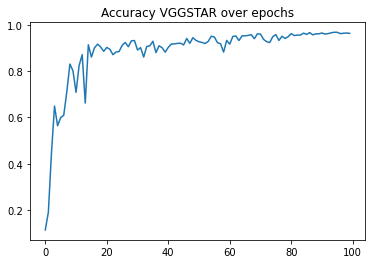

In [ ]:
DO = 'TRAIN'
if (DO=='TRAIN'):
  train(nets, loaders, optimizer, criterion, epochs=100, dev=dev,save_param=True)
else:
  state_dicts = torch.load('model.pth')
  model1.load_state_dict(state_dicts['vgg_a']) #questi state_dict vengono dalla funzione di training
  model2.load_state_dict(state_dicts['vgg_b'])
  model3.load_state_dict(state_dicts['vgg_star'])
  classifier.load_state_dict(state_dicts['classifier'])

  test(model1,classifier,test_loader_all)
  test(model2, classifier, test_loader_all)
  test(model3, classifier, test_loader_all)

  summed_state_dict = OrderedDict()

  for key in state_dicts['vgg_star']:
    if key.find('conv') >=0:
      print(key)
      summed_state_dict[key] = combo_fn(state_dicts['vgg_a'][key],state_dicts['vgg_b'][key])
    else:
      summed_state_dict[key] = state_dicts['vgg_star'][key]

  model3.load_state_dict(summed_state_dict)
  test(model3, classifier, test_loader_all)

In [ ]:
!pip install --upgrade progressbar2

  Attempting uninstall: progressbar2
    Found existing installation: progressbar2 3.38.0
    Uninstalling progressbar2-3.38.0:
      Successfully uninstalled progressbar2-3.38.0
